In [ ]:
!pip install pycuda numba


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 8.9 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1-cp311-cp311-linux_x86_64.whl size=660425 sha256=40bc9bb891c203ba7a8108a19a3dffdc6951f826368a141f1aa7e0a1a17ce028
  Stored in directory: /root/.cache/pip/wheels/77/7e/6c/d2d1451ea6424cdc3d67b36c16fa7111eafdf2034bc3405666
Successfully built pycuda



📏 Testing size: 256x192


/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()



📏 Testing size: 512x384

📏 Testing size: 768x576

📏 Testing size: 1024x768

📏 Testing size: 1600x1200

📊 Execution Time Table:
Resolution  Grid Time (No Numba)  Grid Time (Numba)  GPU Compute Time
   256x192                0.0394             0.8978            0.0002
   512x384                0.0925             0.0006            0.0003
   768x576                0.1929             0.0006            0.0010
  1024x768                0.3456             0.0020            0.0008
 1600x1200                0.8344             0.0021            0.0034
 
 


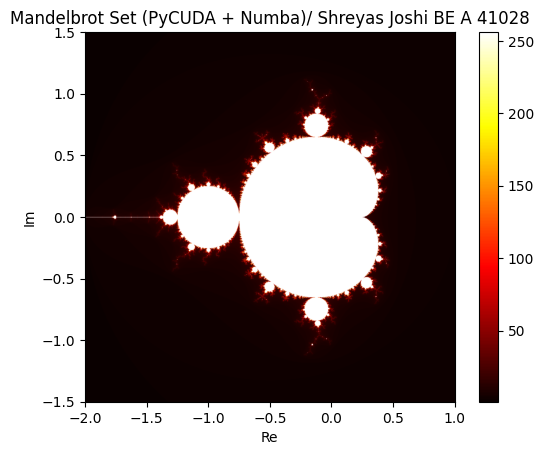

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from numba import njit, prange
import time
import pandas as pd

# Mandelbrot parameters
MAX_ITER = 256
RE_START, RE_END = -2.0, 1.0
IM_START, IM_END = -1.5, 1.5

# Different input sizes to test
input_sizes = [
    (256, 192),
    (512, 384),
    (768, 576),
    (1024, 768),
    (1600, 1200)
]

# ========== CPU Grid Prep (No Numba) ==========
def prepare_grid_python(width, height):
    real = np.empty((height, width), dtype=np.float32)
    imag = np.empty((height, width), dtype=np.float32)
    for y in range(height):
        for x in range(width):
            real[y, x] = RE_START + x * (RE_END - RE_START) / width
            imag[y, x] = IM_START + y * (IM_END - IM_START) / height
    return real, imag

# ========== CPU Grid Prep (Numba) ==========
@njit(parallel=True)
def prepare_grid_numba(width, height):
    real = np.empty((height, width), dtype=np.float32)
    imag = np.empty((height, width), dtype=np.float32)
    for y in prange(height):
        for x in range(width):
            real[y, x] = RE_START + x * (RE_END - RE_START) / width
            imag[y, x] = IM_START + y * (IM_END - IM_START) / height
    return real, imag

# ========== CUDA Kernel ==========
kernel_code = """
__global__ void mandelbrot_kernel(unsigned short *output, float *real, float *imag, int width, int height, int max_iter) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    int i = y * width + x;
    float c_re = real[i];
    float c_im = imag[i];
    float z_re = 0.0, z_im = 0.0;
    int iter = 0;

    while (z_re*z_re + z_im*z_im <= 4.0f && iter < max_iter) {
        float temp = z_re*z_re - z_im*z_im + c_re;
        z_im = 2.0f * z_re * z_im + c_im;
        z_re = temp;
        iter++;
    }

    output[i] = iter;
}
"""

# Compile with specific architecture to avoid PTX version errors
mod = SourceModule(kernel_code, options=["--ptxas-options=-v", "-arch=sm_52"])
mandelbrot_kernel = mod.get_function("mandelbrot_kernel")

# ========== Combined Function ==========
def run_mandelbrot(width, height, use_numba):
    # Grid Preparation
    start = time.time()
    if use_numba:
        real, imag = prepare_grid_numba(width, height)
    else:
        real, imag = prepare_grid_python(width, height)
    prep_time = time.time() - start

    # Allocate and Copy to GPU
    output = np.zeros((height * width), dtype=np.uint16)
    real_gpu = drv.mem_alloc(real.nbytes)
    imag_gpu = drv.mem_alloc(imag.nbytes)
    output_gpu = drv.mem_alloc(output.nbytes)

    drv.memcpy_htod(real_gpu, real.ravel())
    drv.memcpy_htod(imag_gpu, imag.ravel())

    block = (16, 16, 1)
    grid = ((width + 15) // 16, (height + 15) // 16)

    # Run kernel
    start = time.time()
    mandelbrot_kernel(output_gpu, real_gpu, imag_gpu,
                      np.int32(width), np.int32(height), np.int32(MAX_ITER),
                      block=block, grid=grid)
    drv.memcpy_dtoh(output, output_gpu)
    compute_time = time.time() - start

    return prep_time, compute_time, output.reshape((height, width))

# ========== Benchmarking ==========
results = []

for width, height in input_sizes:
    print(f"\n📏 Testing size: {width}x{height}")

    prep_py, compute_py, _ = run_mandelbrot(width, height, use_numba=False)
    prep_numba, compute_numba, _ = run_mandelbrot(width, height, use_numba=True)

    results.append({
        "Resolution": f"{width}x{height}",
        "Grid Time (No Numba)": round(prep_py, 4),
        "Grid Time (Numba)": round(prep_numba, 4),
        "GPU Compute Time": round(compute_numba, 4)
    })

# ========== Show Table ==========
df = pd.DataFrame(results)
print("\n📊 Execution Time Table:")
print(df.to_string(index=False))
print(" ")
print(" ")print(" ")
 #========== Optional Plot ==========
 #Uncomment to visualize one of the outputs
plt.imshow(_, cmap='hot', extent=(RE_START, RE_END, IM_START, IM_END))
plt.title("Mandelbrot Set (PyCUDA + Numba)/ Shreyas Joshi BE A 41028")
plt.colorbar()
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()
